# ResNet50 from Scratch — Identity Block, Convolutional Block, and Full Architecture

---

## 1️⃣ Residual Learning: Why ResNet?

Deep neural networks suffer from:

- **Vanishing gradients**
- **Degradation problem** (training accuracy worsens as depth increases)

ResNet introduces **skip connections (identity shortcuts)** to allow gradients to flow directly.

Instead of learning:

$$
H(x)
$$

ResNet learns the residual:

$$
F(x) = H(x) - x
$$

So the output becomes:

$$
H(x) = F(x) + x
$$

This improves:

- Gradient flow
- Training stability
- Convergence speed

---

## 2️⃣ Batch Normalization (BN)

BatchNorm normalizes activations per batch:

$$
\hat{x} = \frac{x - \mu_B}{\sqrt{\sigma_B^2 + \epsilon}}
$$

Then scales and shifts:

$$
y = \gamma \hat{x} + \beta
$$

Where:
- $( \mu_B )$ = batch mean  
- $( \sigma_B^2 )$ = batch variance  
- $( \gamma, \beta )$ = learnable parameters  
- $( \epsilon )$ = small constant  

### Two Modes

**Training Mode**
- Uses batch statistics
- Updates moving averages

**Inference Mode**
- Uses stored moving averages
- Does NOT update them

---



In [19]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

# Pretrained ResNet50V2 model and utilities
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet_v2 import preprocess_input, decode_predictions

# Core Keras layers
from tensorflow.keras import layers
from tensorflow.keras.layers import (
    Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D,
    AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D, GlobalAveragePooling2D
)

# Model utilities
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import RandomUniform, GlorotUniform, Constant, Identity, random_uniform, glorot_uniform, constant

# Visualization
from tensorflow.keras.utils import plot_model, model_to_dot
from IPython.display import SVG

# Custom utilities 
from resnets_utils import *
from test_utils import summary, comparator
import public_tests

%matplotlib inline


# Identity Block

Used when input and output dimensions are the same.

Structure:
Input
│
Conv → BN → ReLU
│
Conv → BN → ReLU
│
Conv → BN
│
Add Shortcut
│
ReLU


Mathematically:

$$
Y = \text{ReLU}(F(X) + X)
$$

---

In [20]:


def identity_block(X, f, filters, training=True, initializer=random_uniform):
    """
    Implementation of the identity block (ResNet).
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- list of integers, defining the number of filters in the CONV layers of the main path
    training -- True: Behave in training mode (update BN stats)
                False: Inference mode (use moving averages in BN)
    initializer -- initializer function for Conv2D kernels
    
    Returns:
    X -- output tensor of the identity block
    """
    
    # Retrieve filters
    F1, F2, F3 = filters
    
    # Save the input value for the shortcut
    X_shortcut = X
    
    # First component of main path
    X = Conv2D(filters=F1, kernel_size=1, strides=(1,1), padding='valid',
               kernel_initializer=initializer(seed=0))(X)
    X = BatchNormalization(axis=3, momentum=0.99, epsilon=0.001)(X)
    X = Activation('relu')(X)
    
    # Second component of main path
    X = Conv2D(filters=F2, kernel_size=f, strides=(1,1), padding='same',
               kernel_initializer=initializer(seed=0))(X)
    X = BatchNormalization(axis=3, momentum=0.99, epsilon=0.001)(X)
    X = Activation('relu')(X)
    
    # Third component of main path
    X = Conv2D(filters=F3, kernel_size=1, strides=(1,1), padding='valid',
               kernel_initializer=initializer(seed=0))(X)
    X = BatchNormalization(axis=3, momentum=0.99, epsilon=0.001)(X)
    
    # Final step: Add shortcut and pass through ReLU
    X = Add()([X_shortcut, X])
    X = Activation('relu')(X)
    
    return X


In [21]:


np.random.seed(1)
X1 = np.ones((1, 4, 4, 3)) * -1
X2 = np.ones((1, 4, 4, 3)) * 1
X3 = np.ones((1, 4, 4, 3)) * 3
X = np.concatenate((X1, X2, X3), axis=0).astype(np.float32)

# Inference mode (BN not updated)
A3 = identity_block(X, f=2, filters=[4,4,3],
                    initializer=lambda seed=0: constant(value=1),
                    training=False)
print("With training=False\n")
print(np.around(A3.numpy()[:,(0,-1),:,:].mean(axis=3), 5))

# Training mode (BN updated)
np.random.seed(1)
A4 = identity_block(X, f=2, filters=[3,3,3],
                    initializer=lambda seed=0: constant(value=1),
                    training=True)
print("\nWith training=True\n")
print(np.around(A4.numpy()[:,(0,-1),:,:].mean(axis=3), 5))


With training=False

[[[  0.        0.        0.        0.     ]
  [  0.        0.        0.        0.     ]]

 [[192.71233 192.71233 192.71233  96.85616]
  [ 96.85616  96.85616  96.85616  48.92808]]

 [[578.13684 578.13684 578.13684 290.56848]
  [290.56848 290.56848 290.56848 146.78424]]]

With training=True

[[[  0.        0.        0.        0.     ]
  [  0.        0.        0.        0.     ]]

 [[108.8382  108.8382  108.8382   54.9191 ]
  [ 54.9191   54.9191   54.9191   27.95956]]

 [[326.51465 326.51465 326.51465 164.75731]
  [164.75731 164.75731 164.75731  83.87866]]]


### Identity Block — Key Insights

- No change in spatial dimensions
- Shortcut is pure identity
- Enables residual learning
- Crucial for deep stability

# Convolutional Block

Used when dimensions must change (downsampling).

Difference:
- First conv uses stride `s`
- Shortcut also has Conv layer

Mathematically:

$$
Y = \text{ReLU}(F(X) + W_s X)
$$

Where $( W_s )$ projects dimensions.

Structure:

Input
│
Conv(stride s) → BN → ReLU
│
Conv → BN → ReLU
│
Conv → BN
│
Shortcut Conv(stride s) → BN
│
Add
│
ReLU


In [22]:


def convolutional_block(X, f, filters, s=2, training=True, initializer=glorot_uniform):
    """
    Implementation of the convolutional block (ResNet).
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- list of integers, defining the number of filters in the CONV layers of the main path
    s -- stride to be used in the first conv layer and the shortcut path
    training -- True: Behave in training mode (update BN stats)
                False: Inference mode (use moving averages in BN)
    initializer -- initializer function for Conv2D kernels (default GlorotUniform)
    
    Returns:
    X -- output tensor of the convolutional block
    """
    
    # Retrieve filters
    F1, F2, F3 = filters
    
    # Save the input value for the shortcut
    X_shortcut = X
    
    ##### MAIN PATH #####
    # First component
    X = Conv2D(filters=F1, kernel_size=1, strides=(s,s), padding='valid',
               kernel_initializer=initializer(seed=0))(X)
    X = BatchNormalization(axis=3, momentum=0.99, epsilon=0.001)(X)
    X = Activation('relu')(X)
    
    # Second component
    X = Conv2D(filters=F2, kernel_size=f, strides=(1,1), padding='same',
               kernel_initializer=initializer(seed=0))(X)
    X = BatchNormalization(axis=3, momentum=0.99, epsilon=0.001)(X)
    X = Activation('relu')(X)
    
    # Third component
    X = Conv2D(filters=F3, kernel_size=1, strides=(1,1), padding='valid',
               kernel_initializer=initializer(seed=0))(X)
    X = BatchNormalization(axis=3, momentum=0.99, epsilon=0.001)(X)
    
    ##### SHORTCUT PATH #####
    X_shortcut = Conv2D(filters=F3, kernel_size=1, strides=(s,s), padding='valid',
                        kernel_initializer=initializer(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis=3, momentum=0.99, epsilon=0.001)(X_shortcut)
    
    ##### FINAL STEP #####
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    return X


In [23]:
np.random.seed(1)
X1 = np.ones((1, 4, 4, 3)) * -1
X2 = np.ones((1, 4, 4, 3)) * 1
X3 = np.ones((1, 4, 4, 3)) * 3
X = np.concatenate((X1, X2, X3), axis=0).astype(np.float32)

# Inference mode
A = convolutional_block(X, f=2, filters=[2,4,6], training=False)
print("Output shape:", A.shape)
print("Sample output (training=False):\n", A[0].numpy())

# Training mode
B = convolutional_block(X, f=2, filters=[2,4,6], training=True)
print("Output shape:", B.shape)
print("Sample output (training=True):\n", B[0].numpy())


Output shape: (3, 2, 2, 6)
Sample output (training=False):
 [[[0.         0.6668381  0.         0.         0.888539   0.5274254 ]
  [0.         0.6505366  0.         0.         0.8959285  0.49965227]]

 [[0.         0.6312078  0.         0.         0.86362475 0.47643146]
  [0.         0.56883204 0.         0.         0.8553412  0.417093  ]]]
Output shape: (3, 2, 2, 6)
Sample output (training=True):
 [[[0.         0.6668381  0.         0.         0.888539   0.5274254 ]
  [0.         0.6505366  0.         0.         0.8959285  0.49965227]]

 [[0.         0.6312078  0.         0.         0.86362475 0.47643146]
  [0.         0.56883204 0.         0.         0.8553412  0.417093  ]]]


### Convolutional Block — Key Insights

- Changes feature map dimensions
- Learns both transformation and projection
- Enables hierarchical depth expansion

# Full ResNet50 Architecture (Simplified for 64×64)

ResNet50 consists of:

- Initial Conv layer
- 4 Residual stages
- Each stage increases depth
- Final average pooling
- Fully connected classification

Layer progression:

| Stage | Output Depth |
|-------|-------------|
| Conv1 | 64 |
| Stage2 | 256 |
| Stage3 | 512 |
| Stage4 | 1024 |
| Stage5 | 2048 |

Total layers ≈ 50

In [24]:
def ResNet50(input_shape=(64,64,3), classes=6):
    """
    Implementation of ResNet50 (simplified for 64x64 input).
    
    Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of output classes
    
    Returns:
    model -- a Keras Model instance
    """
    
    # Input
    X_input = Input(input_shape)

     # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)
    
    # Stage 1
    X = Conv2D(64, (7,7), strides=(2,2), kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, momentum=0.99, epsilon=0.001)(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3,3), strides=(2,2))(X)
    
    # Stage 2
    X = convolutional_block(X, f=3, filters=[64,64,256], s=1)
    X = identity_block(X, 3, [64,64,256])
    X = identity_block(X, 3, [64,64,256])
    
    # Stage 3
    X = convolutional_block(X, f=3, filters=[128,128,512], s=2)
    X = identity_block(X, 3, [128,128,512])
    X = identity_block(X, 3, [128,128,512])
    X = identity_block(X, 3, [128,128,512])
    
    # Stage 4
    X = convolutional_block(X, f=3, filters=[256,256,1024], s=2)
    X = identity_block(X, 3, [256,256,1024])
    X = identity_block(X, 3, [256,256,1024])
    X = identity_block(X, 3, [256,256,1024])
    X = identity_block(X, 3, [256,256,1024])
    X = identity_block(X, 3, [256,256,1024])
    
    # Stage 5
    X = convolutional_block(X, f=3, filters=[512,512,2048], s=2)
    X = identity_block(X, 3, [512,512,2048])
    X = identity_block(X, 3, [512,512,2048])
    
    # Average Pooling
    X = AveragePooling2D((2,2))(X)
    # X = GlobalAveragePooling2D()(X)
    
    # Output layer
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', kernel_initializer=glorot_uniform(seed=0))(X)
    
    # Create model
    model = Model(inputs=X_input, outputs=X, name="ResNet50")
    
    return model


In [25]:
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_dataset()

# Normalize image vectors
X_train = X_train_orig / 255.
X_test = X_test_orig / 255.

# Convert training and test labels to one hot matrices
Y_train = convert_to_one_hot(Y_train_orig, 6).T
Y_test = convert_to_one_hot(Y_test_orig, 6).T

print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

number of training examples = 1080
number of test examples = 120
X_train shape: (1080, 64, 64, 3)
Y_train shape: (1080, 6)
X_test shape: (120, 64, 64, 3)
Y_test shape: (120, 6)


In [26]:

model = ResNet50(input_shape=(64,64,3), classes=6)
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train 
model.fit(X_train, Y_train, epochs=10, batch_size=32)

# Evaluate
preds = model.evaluate(X_test, Y_test)
print("Loss = " + str(preds[0]))
print("Test Accuracy = " + str(preds[1]))

Epoch 1/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 195s 2s/step - accuracy: 0.5056 - loss: 2.4582
Epoch 2/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 66s 2s/step - accuracy: 0.6843 - loss: 1.0260
Epoch 3/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - accuracy: 0.8083 - loss: 0.8199
Epoch 4/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - accuracy: 0.8093 - loss: 0.6467
Epoch 5/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 65s 2s/step - accuracy: 0.9093 - loss: 0.3027
Epoch 6/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - accuracy: 0.9630 - loss: 0.1479
Epoch 7/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - accuracy: 0.9491 - loss: 0.2071
Epoch 8/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - accuracy: 0.9287 - loss: 0.2483
Epoch 9/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - accuracy: 0.9556 - loss: 0.1458
Epoch 10/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 64s 2s/step - accuracy: 0.9639 - loss: 0.1236
4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 382ms/step - accuracy: 0.2417 - loss: 6.9042
Loss = 6.9042134284973145
Test Accuracy = 0.24166665971279144


# Training the Model

Loss function:

For multi-class classification:

$$
\mathcal{L} = -\sum_{i=1}^{C} y_i \log(\hat{y}_i)
$$

Where:
- $( y_i )$ = true label
- $( \hat{y}_i )$ = predicted probability

Optimizer: Adam  
Batch size: 32  
Epochs: 10  

---

In [ ]:
# Summary
model.summary()

Model: "ResNet50"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)    │ (None, 64, 64, 3)         │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ zero_padding2d_1              │ (None, 70, 70, 3)         │               0 │ input_layer_1[0][0]        │
│ (ZeroPadding2D)               │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_67 (Conv2D)            │ (None, 32, 32, 64)        │           9,472 │ zero_padding2d_1[0][0]     │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_67        │ (None, 32, 32, 64)        │             256 │ conv2d_67[0][0]            │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_61 (Activation)    │ (None, 32, 32, 64)        │               0 │ batch_normalization_67[0]… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_1               │ (None, 15, 15, 64)        │               0 │ activation_61[0][0]        │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_68 (Conv2D)            │ (None, 15, 15, 64)        │           4,160 │ max_pooling2d_1[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_68        │ (None, 15, 15, 64)        │             256 │ conv2d_68[0][0]            │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_62 (Activation)    │ (None, 15, 15, 64)        │               0 │ batch_normalization_68[0]… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_69 (Conv2D)            │ (None, 15, 15, 64)        │          36,928 │ activation_62[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_69        │ (None, 15, 15, 64)        │             256 │ conv2d_69[0][0]            │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_63 (Activation)    │ (None, 15, 15, 64)        │               0 │ batch_normalization_69[0]… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_70 (Conv2D)            │ (None, 15, 15, 256)       │          16,640 │ activation_63[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_71 (Conv2D)            │ (None, 15, 15, 256)       │          16,640 │ max_pooling2d_1[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_70        │ (None, 15, 15, 256)       │           1,02

In [ ]:
print(model.history.history)

# Using a Pretrained Model

Transfer learning allows leveraging learned features from large datasets.

Advantages:
- Faster convergence
- Better generalization
- Less data required

Procedure:
1. Load pretrained weights
2. Compile
3. Fine-tune

In [29]:
pre_trained_model = tf.keras.models.load_model('resnet50.h5', compile=False)

pre_trained_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

pre_trained_model.fit(X_train, Y_train, epochs=10, batch_size=32)

# Evaluate
pre_trained_preds = pre_trained_model.evaluate(X_test, Y_test)
print("Loss =", pre_trained_preds[0])
print("Test Accuracy =", pre_trained_preds[1])

34/34 ━━━━━━━━━━━━━━━━━━━━ 105s 3s/step - accuracy: 0.9194 - loss: 0.2606
Epoch 3/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 88s 3s/step - accuracy: 0.9120 - loss: 0.2615
Epoch 4/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 147s 3s/step - accuracy: 0.9269 - loss: 0.2756
Epoch 5/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 86s 3s/step - accuracy: 0.7556 - loss: 1.2896
Epoch 6/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 136s 2s/step - accuracy: 0.8509 - loss: 0.6057
Epoch 7/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - accuracy: 0.9380 - loss: 0.1736
Epoch 8/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 77s 2s/step - accuracy: 0.8176 - loss: 0.6193
Epoch 9/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - accuracy: 0.9000 - loss: 0.3135
Epoch 10/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 88s 3s/step - accuracy: 0.9583 - loss: 0.1328
4/4 ━━━━━━━━━━━━━━━━━━━━ 43s 406ms/step - accuracy: 0.6917 - loss: 1.2265
Loss = 1.226515531539917
Test Accuracy = 0.6916666626930237


In [30]:
pre_trained_model.summary()

Model: "ResNet50"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_1 (InputLayer)          │ (None, 64, 64, 3)         │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ zero_padding2d_1              │ (None, 70, 70, 3)         │               0 │ input_1[0][0]              │
│ (ZeroPadding2D)               │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1 (Conv2D)                │ (None, 32, 32, 64)        │           9,472 │ zero_padding2d_1[0][0]     │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bn_conv1 (BatchNormalization) │ (None, 32, 32, 64)        │             256 │ conv1[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_4 (Activation)     │ (None, 32, 32, 64)        │               0 │ bn_conv1[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_1               │ (None, 15, 15, 64)        │               0 │ activation_4[0][0]         │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ res2a_branch2a (Conv2D)       │ (None, 15, 15, 64)        │           4,160 │ max_pooling2d_1[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bn2a_branch2a                 │ (None, 15, 15, 64)        │             256 │ res2a_branch2a[0][0]       │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_5 (Activation)     │ (None, 15, 15, 64)        │               0 │ bn2a_branch2a[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ res2a_branch2b (Conv2D)       │ (None, 15, 15, 64)        │          36,928 │ activation_5[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bn2a_branch2b                 │ (None, 15, 15, 64)        │             256 │ res2a_branch2b[0][0]       │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_6 (Activation)     │ (None, 15, 15, 64)        │               0 │ bn2a_branch2b[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ res2a_branch2c (Conv2D)       │ (None, 15, 15, 256)       │          16,640 │ activation_6[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ res2a_branch1 (Conv2D)        │ (None, 15, 15, 256)       │          16,640 │ max_pooling2d_1[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bn2a_branch2c                 │ (None, 15, 15, 256)       │           1,024 │ res2a_branch2c[0][0]       │
│ (BatchNormalization)          │                           │               

 Total params: 70,693,780 (269.68 MB)

 Trainable params: 23,546,886 (89.82 MB)

 Non-trainable params: 53,120 (207.50 KB)

 Optimizer params: 47,093,774 (179.65 MB)

# Final Key Takeaways

- Residual connections solve degradation problem
- BatchNorm stabilizes deep training
- Identity block preserves dimensions
- Convolutional block changes dimensions
- ResNet50 uses hierarchical feature expansion
- Proper training/inference BN handling is critical
- Transfer learning significantly improves performance

---



Input image shape: (1, 64, 64, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 106s 106s/step
Class prediction vector [p(0), p(1), p(2), p(3), p(4), p(5)] =  [[2.7169134e-02 2.7535539e-04 8.2550859e-03 7.2181828e-02 8.9174283e-01
  3.7577850e-04]]
Class: 4


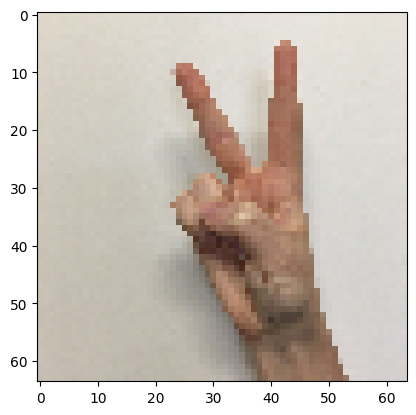

In [31]:
img_path = 'images/my_image.jpg'
img = image.load_img(img_path, target_size=(64, 64))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = x/255.0
print('Input image shape:', x.shape)
imshow(img)
prediction = pre_trained_model.predict(x)
print("Class prediction vector [p(0), p(1), p(2), p(3), p(4), p(5)] = ", prediction)
print("Class:", np.argmax(prediction))